In [230]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import argparse
import numpy as np
import numpy.typing as npt
import pandas as pd
import yaml

from pathlib import Path
from tqdm import tqdm
from tensorflow import data
from tensorflow.keras.models import load_model

from utils import IsValidFile, IsReadableDir, CreateFolder, predict_single_image
from generator import RegionETGenerator

import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use('CMS')

from typing import List

import json

import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model



In [231]:
def loss(y_true: npt.NDArray, y_pred: npt.NDArray) -> npt.NDArray:
    return np.mean((y_true - y_pred) ** 2, axis=(1, 2, 3))

def quantize(arr: npt.NDArray, precision: tuple = (16, 8)) -> npt.NDArray:
    word, int_ = precision
    decimal = word - int_
    step = 1 / 2**decimal
    max_ = 2**int_ - step
    arrq = step * np.round(arr / step)
    arrc = np.clip(arrq, 0, max_)
    return arrc


def get_deposits(datasets):
    generator = RegionETGenerator()
    deposits, labels = [], []
    for dataset in datasets:
        name = dataset["name"]
        X = generator.get_data(dataset["path"])
        print(f"{name} samples: {X.shape[0]}")
        deposits.append(X)
        labels.append(name)
    return deposits, labels

In [232]:
INTERACTIVE = True
OUT_DIR = 'plots/deep-dive'

def save_fig(name: str):
    plt.savefig(
        f"{OUT_DIR}/{name}.png", bbox_inches="tight"
    )
    if INTERACTIVE:
        plt.show()
    plt.close()

In [234]:
# setup data loaders & load models
config = yaml.safe_load(open('misc/config-macbook-deep-dive.yml'))

datasets = [i["path"] for i in config["background"] if i["use"]]
datasets = [path for paths in datasets for path in paths]

gen = RegionETGenerator()
(X_train, X_val, X_test), (npv_train, npv_val, npv_test) = gen.get_data_split(datasets, get_npv=True)

idx_train, idx_val, idx_test = (npv_train>10), (npv_val>10), (npv_test>10)
X_train, X_val, X_test = X_train[idx_train], X_val[idx_val], X_test[idx_test]

npv_train, npv_val, npv_test = npv_train[idx_train], npv_val[idx_val], npv_test[idx_test]


In [ ]:
# make NPV dist plots
plt.hist(np.concatenate([npv_train, npv_test, npv_val]), bins=range(80), density=True)
plt.xlabel("nPV")
plt.ylabel("a.u.")
save_fig("npv-dist")

1/1 [==============================] - 0s 9ms/step


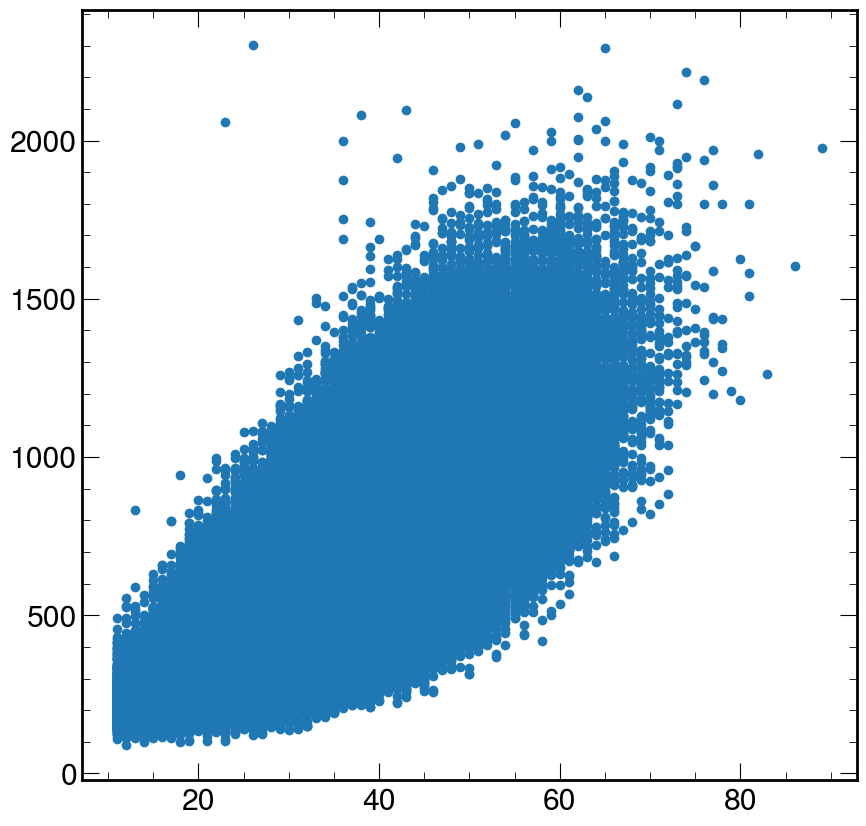

In [89]:
num_zeros = (X_train == 0).sum(axis=(1,2,3))
et_sum = X_train.sum(axis=(1,2,3))
et_squared_sum = (X_train**2).sum(axis=(1,2,3))
#plt.scatter(npv_train, num_zeros)
plt.scatter(npv_train, et_sum)
# plt.gca().set_ylim([0, 25000])

preds = teacher_w.predict(X_test[:10])
# print(preds)

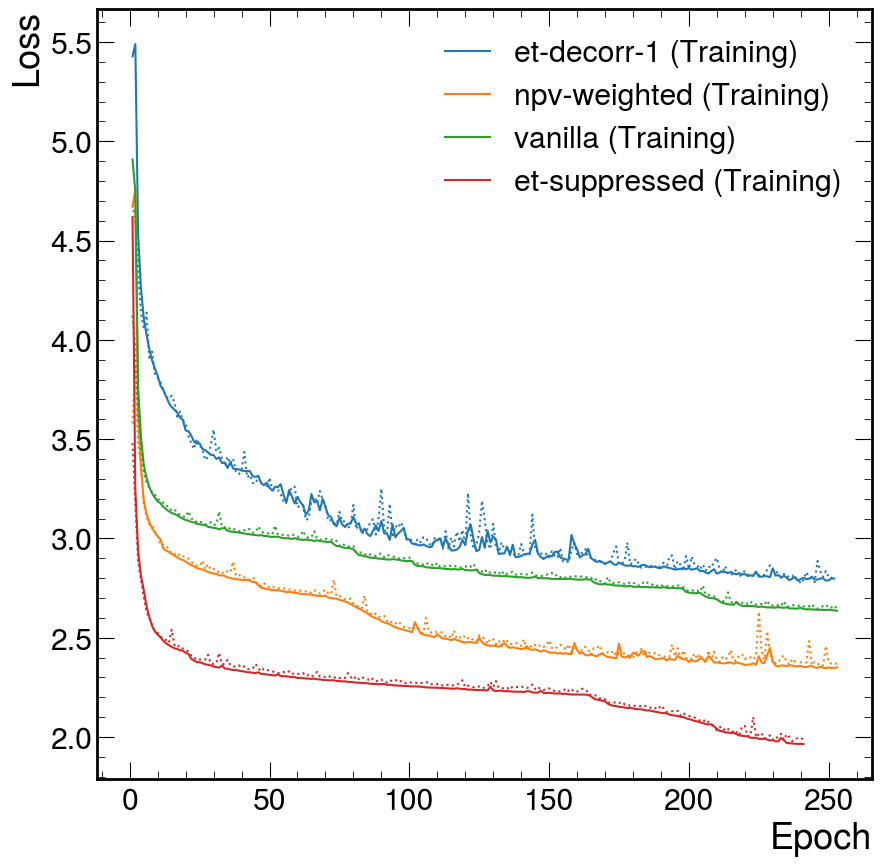

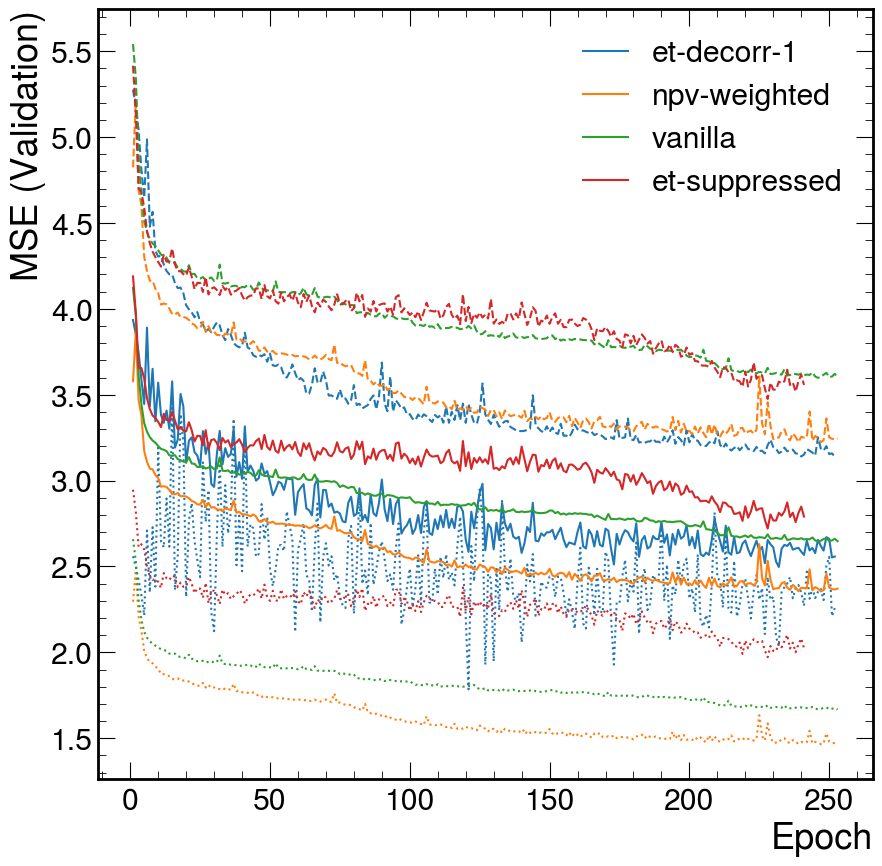

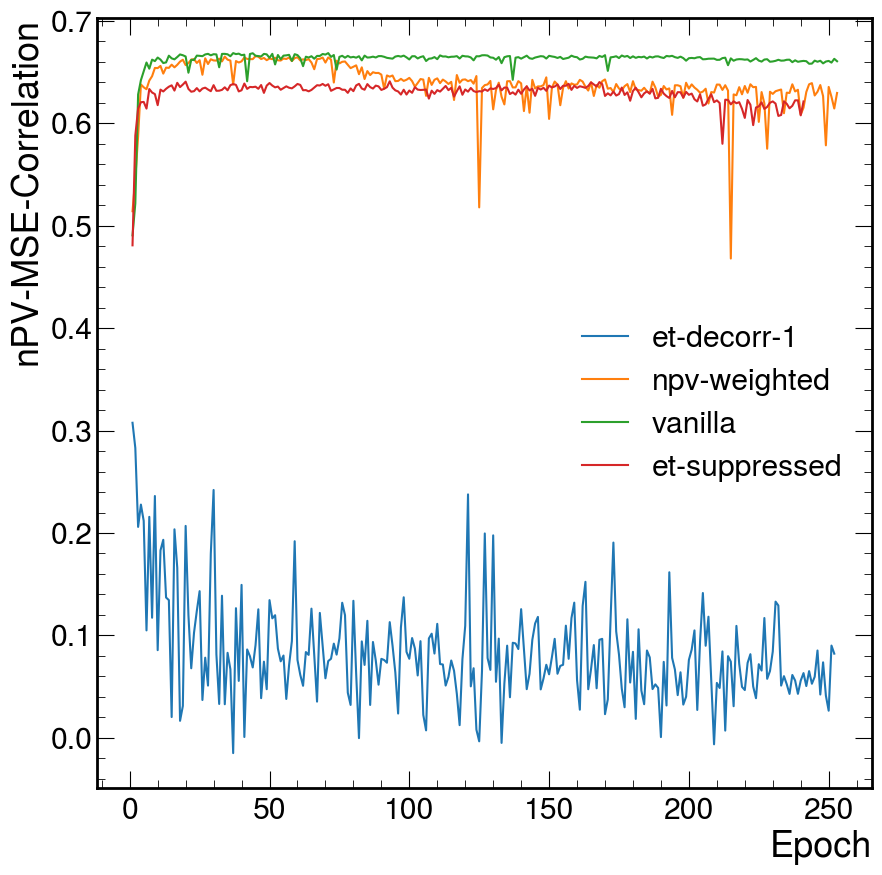

In [171]:
# Loss curves
def plot_loss_histories(
    loss_dict: dict[str, (npt.NDArray, npt.NDArray)], name: str
):
    for model_name, (train_loss, val_loss) in loss_dict.items():
        c = next(plt.gca()._get_lines.prop_cycler)['color']
        plt.plot(np.arange(1, len(train_loss) + 1), train_loss, color=c, label=f"{model_name} (Training)")
        plt.plot(np.arange(1, len(val_loss) + 1), val_loss, color=c, ls=":")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    save_fig(name)

def plot_mse_histories(
    mse_dict: dict[str, (npt.NDArray, npt.NDArray, npt.NDArray)], name: str
):
    for model_name, (mse, mse_low_npv, mse_high_npv) in mse_dict.items():
        c = next(plt.gca()._get_lines.prop_cycler)['color']
        plt.plot(np.arange(1, len(mse) + 1), mse, color=c, label=model_name)
        plt.plot(np.arange(1, len(mse_low_npv) + 1), mse_low_npv, color=c, linestyle=":")
        plt.plot(np.arange(1, len(mse_high_npv) + 1), mse_high_npv, color=c, linestyle="--")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch")
    plt.ylabel("MSE (Validation)")
    save_fig(name)

def plot_corr_histories(
    loss_dict: dict[str, npt.NDArray], name: str
):
    for model_name, corrs in loss_dict.items():
        c = next(plt.gca()._get_lines.prop_cycler)['color']
        plt.plot(np.arange(1, len(corrs) + 1), corrs, color=c, label=f"{model_name}")
        # plt.plot(np.arange(1, len(val_loss) + 1), val_loss, color=c, ls=":")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("nPV-MSE-Correlation")
    save_fig(name)


losses, corrs, mses = {}, {}, {}
# for name in ["et-decorr-05", "et-decorr-1", "npv-weighted", "revised", "vanilla", "et-suppressed", "et-suppressed-uw"]:
# for name in ["et-decorr-05", "et-decorr-1", "npv-weighted", "vanilla", "et-suppressed"]:#, "et-suppressed-uw"]:
for name in ["et-decorr-1", "npv-weighted", "vanilla", "et-suppressed"]:#, "et-suppressed-uw"]:
    log = pd.read_csv(f"models/deep-dive/from-lxplus/latest/{name}.log")
    losses[name] = (log["loss"], log["val_loss"])
    corrs[name] = log["npv_mse_corr"]
    mses[name] = (log["mse"], log["mse_low_npv"], log["mse_high_npv"])

plot_loss_histories(losses, "loss-histories")
plot_mse_histories(mses, "mse-histories")
plot_corr_histories(corrs, "corr-histories")


# plt.figure(figsize=(9, 7))
# fig, ax = plt.subplots()
# ax2 = ax.twinx()
# for name in ["et-decorr-01", "et-decorr-1", "npv-weighted", "revised", "vanilla"]:
#     logs = pd.read_csv(f"models/deep-dive/from-lxplus/latest/{name}.log")
#     c = next(plt.gca()._get_lines.prop_cycler)['color']
#     ax.plot(np.arange(1, len(logs["loss"]) + 1), logs["loss"], label=name, color=c, linewidth=2)
#     ax.plot(np.arange(1, len(logs["val_loss"]) + 1), logs["val_loss"], color=c, linewidth=2, linestyle="--", alpha=0.5)
#     ax2.plot(np.arange(1, len(logs["npv_mse_corr"]) + 1), logs["npv_mse_corr"], color=c, linewidth=2, linestyle="--", alpha=0.5)

# ax.legend(loc="upper right")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Loss")
# save_fig("loss-histories")


In [ ]:
# correlation npv vs anomaly score


# idx = (npv_test>10)
# my_npv = npv_test[idx]
# my_teacher_score = quantize(np.log(results_teacher['2023 Zero Bias'][idx])*32)
# my_student_score = y_loss_background_cicada_v2[idx].flatten()

# scatter_hist(my_npv, my_teacher_score, my_student_score)

In [137]:
def my_mse(y_true, y_pred):
    # First compute MSE per image (reducing across height and width)
    per_image_mse = tf.reduce_mean(
        tf.square(y_true - y_pred),
        axis=[1, 2, 3]  # Reduce across height and width dimensions
    )
    return per_image_mse  # Return per-image loss

class LossMonitorCallback(tf.keras.callbacks.Callback):
    def __init__(self, X, npv):
        super().__init__()
        self.X = X
        self.npv = npv
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        preds = self.model.predict(self.X, batch_size=512)
        losses = tf.reduce_mean(tf.square(self.X - preds), axis=[1,2,3]).numpy()
        
        # Look at average losses for different nPV ranges
        low_npv = self.npv < np.percentile(self.npv, 33)
        high_npv = self.npv > np.percentile(self.npv, 66)

        my_npv = self.npv > 42

        corr = np.corrcoef(self.npv, losses)[0,1]
        logs['npv_mse_corr'] = corr
        
        print(f"\nEpoch {epoch} detailed losses:")
        print(f"Avg loss for low nPV: {losses[low_npv].mean():.4f}")
        print(f"Avg loss for high nPV: {losses[high_npv].mean():.4f}")
        print(f"Avg loss for my nPV: {losses[my_npv].sum() / self.npv.size:.6f}")
        print(f"Correlation: {corr:.4f}")
        

monitor = LossMonitorCallback(X_val, npv_val)  # Use subset for efficiency

with custom_object_scope({'my_mse': my_mse}):
    teacher_w = load_model("models/deep-dive/from-lxplus/teacher")

t_w_mc = ModelCheckpoint(f"models/deep-dive/teacher-w", save_best_only=True)
t_w_log = CSVLogger(f"models/deep-dive/training-w.log", append=True)

teacher_w.compile(optimizer=Adam(learning_rate=0.001), loss=my_mse, weighted_metrics=[])

# ma, mi = npv_train.max(), npv_train.min()
# sample_weights = (npv_train - mi) / (ma - mi)
# val_weights = (npv_val - mi) / (ma - mi)
# sample_weights = sample_weights**2 * 2
# val_weights = val_weights**2 * 2

# Much stronger weighting for high nPV samples
sample_weights = np.exp((npv_train - npv_train.min()) / npv_train.std())
# Normalize to keep loss values in a reasonable range
sample_weights = sample_weights / sample_weights.mean()

val_weights = np.exp((npv_val - npv_train.min()) / npv_train.std())
val_weights = val_weights / val_weights.mean()

sample_weights = (npv_train > 42)
val_weights = (npv_val > 42)


# plt.hist(sample_weights, bins=100)
# plt.hist(val_weights, bins=100)

teacher_w.fit(
    X_train,
    X_train,
    validation_data=(X_val, X_val, val_weights),
    sample_weight=sample_weights,
    batch_size=512,
    epochs=1,
    callbacks=[monitor, t_w_mc, t_w_log],
    verbose=True,
)

239/239 [==============================] - 5s 22ms/step

Epoch 0 detailed losses:
Avg loss for low nPV: 1.6696
Avg loss for high nPV: 3.5825
Avg loss for my nPV: 1.009576
Correlation: 0.6398
INFO:tensorflow:Assets written to: models/deep-dive/teacher-w/assets


INFO:tensorflow:Assets written to: models/deep-dive/teacher-w/assets


1195/1195 [==============================] - 98s 81ms/step - loss: 1.0034 - val_loss: 1.0096 - npv_mse_corr: 0.6398


In [156]:
def et_decorr_loss_1(y_true, y_pred):
    mse = my_mse(y_true, y_pred)
    et_sum = tf.reduce_sum(y_true, axis=(1,2,3))
    mse_centered = mse - tf.reduce_mean(mse)
    et_sum_centered = et_sum - tf.reduce_mean(et_sum)
    correlation = tf.reduce_sum(mse_centered * et_sum_centered) / (
        tf.sqrt(tf.reduce_sum(tf.square(mse_centered))) * 
        tf.sqrt(tf.reduce_sum(tf.square(et_sum_centered)))
    )
    return tf.reduce_mean(mse) + 1 * correlation


def et_decorr_loss_05(y_true, y_pred):
    mse = my_mse(y_true, y_pred)
    et_sum = tf.reduce_sum(y_true, axis=(1,2,3))
    mse_centered = mse - tf.reduce_mean(mse)
    et_sum_centered = et_sum - tf.reduce_mean(et_sum)
    correlation = tf.reduce_sum(mse_centered * et_sum_centered) / (
        tf.sqrt(tf.reduce_sum(tf.square(mse_centered))) * 
        tf.sqrt(tf.reduce_sum(tf.square(et_sum_centered)))
    )
    return tf.reduce_mean(mse) + 0.5 * correlation


def suppressed_mse(y_true, y_pred):
    mask = tf.cast(y_true > 0, tf.float32)
    squared_error = tf.square(y_true - y_pred) * mask
    error_sum = tf.reduce_sum(squared_error, axis=[1, 2, 3])
    n_nonzero = tf.reduce_sum(mask, axis=[1, 2, 3])
    return error_sum / (n_nonzero + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero

In [167]:
from tensorflow.keras.utils import custom_object_scope

# model_dict, scores = {}, {}
# for name in ["vanilla", "revised", "npv-weighted", "et-decorr-1"]:
# for name in ["et-decorr-05", "et-decorr-1", "npv-weighted", "vanilla", "et-suppressed"]:#, "et-suppressed-uw"]:
for name in ["revised"]:#, "et-suppressed-uw"]:
    with custom_object_scope({
        'my_mse': my_mse,
        "et_decorr_loss_1": et_decorr_loss_1,
        "et_decorr_loss_05": et_decorr_loss_05,
        "suppressed_mse": suppressed_mse,
    }):
        model = load_model(f"models/deep-dive/from-lxplus/latest/{name}")
    model_dict[name] = model
    predictions = model.predict(X_test, batch_size=512)
    mse = loss(X_test, predictions)
    scores[name] = quantize(np.log(mse)*32)


956/956 [==============================] - 18s 19ms/step


In [236]:
student = load_model("models/from-eos/cicada-v2")
teacher = load_model("models/from-eos/teacher")

teacher_predictions = teacher.predict(X_test, batch_size=512)
mse = loss(X_test, teacher_predictions)
teacher_scores = quantize(np.log(mse)*32)
student_scores = student.predict(X_test.reshape(-1, 252, 1), batch_size=512).flatten()

956/956 [==============================] - 1s 1ms/step


In [246]:
# teacher_train_mse = loss(X_train, teacher.predict(X_train, batch_size=512))
# targets_vanilla = quantize(np.log(teacher_train_mse)*32)
# targets_scaled = quantize(np.log(teacher_train_mse)*32*32 / npv_train)
# teacher_val_mse = loss(X_val, teacher.predict(X_val, batch_size=512))
# targets_vanilla_val = quantize(np.log(teacher_val_mse)*32)
# targets_scaled_val = quantize(np.log(teacher_val_mse)*32*32 / npv_val)

scatter_hist(npv_train,
             [targets_vanilla, targets_scaled],
             ["vanilla student targets",
              "novel student targets"])


239/239 [==============================] - 8s 35ms/step


In [250]:
from models import CicadaV2

student_re = CicadaV2((252,)).get_model()
student_re.compile(optimizer=Adam(learning_rate=0.001), loss="mae")

mc = ModelCheckpoint(f"models/deep-dive/student-re", save_best_only=True)
log = CSVLogger(f"models/deep-dive/student-re.log", append=True)

student_re.fit(
    X_train.reshape((-1, 252, 1)),
    targets_scaled,
    validation_data=(X_val.reshape((-1, 252, 1)), targets_scaled_val),
    batch_size=512,
    epochs=10,
    callbacks=[mc, log],
    verbose=True,
)


Epoch 1/10
1193/1195 [============================>.] - ETA: 0s - loss: 17.0317INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


1195/1195 [==============================] - 8s 6ms/step - loss: 17.0223 - val_loss: 7.0423
Epoch 2/10
  11/1195 [..............................] - ETA: 12s - loss: 7.2117

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


1188/1195 [============================>.] - ETA: 0s - loss: 6.4436INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


1195/1195 [==============================] - 6s 5ms/step - loss: 6.4426 - val_loss: 5.2594
Epoch 3/10
  46/1195 [>.............................] - ETA: 4s - loss: 6.0101

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


1195/1195 [==============================] - 5s 4ms/step - loss: 6.0208 - val_loss: 5.3381
Epoch 4/10
1189/1195 [============================>.] - ETA: 0s - loss: 5.9569INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


1195/1195 [==============================] - 6s 5ms/step - loss: 5.9564 - val_loss: 5.2266
Epoch 5/10
  36/1195 [..............................] - ETA: 5s - loss: 5.9393

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


1195/1195 [==============================] - 5s 4ms/step - loss: 5.9099 - val_loss: 5.3667
Epoch 6/10
1195/1195 [==============================] - 4s 4ms/step - loss: 5.8634 - val_loss: 5.2409
Epoch 7/10
1195/1195 [==============================] - 4s 4ms/step - loss: 5.8404 - val_loss: 5.2544
Epoch 8/10
1181/1195 [============================>.] - ETA: 0s - loss: 5.8380INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


1195/1195 [==============================] - 5s 5ms/step - loss: 5.8385 - val_loss: 5.2217
Epoch 9/10
  42/1195 [>.............................] - ETA: 4s - loss: 5.8069

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


1186/1195 [============================>.] - ETA: 0s - loss: 5.8283INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


1195/1195 [==============================] - 5s 5ms/step - loss: 5.8284 - val_loss: 5.2106
Epoch 10/10
  40/1195 [>.............................] - ETA: 4s - loss: 5.8463

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


1195/1195 [==============================] - 5s 4ms/step - loss: 5.8176 - val_loss: 5.2405


In [ ]:
student = load_model("models/from-eos/cicada-v2")
teacher = load_model("models/from-eos/teacher")

# teacher_predictions = teacher.predict(X_test, batch_size=512)
# mse = loss(X_test, teacher_predictions)
# teacher_scores = quantize(np.log(mse)*32)
# student_scores = student.predict(X_test.reshape(-1, 252, 1), batch_size=512).flatten()

idx = (X_test<=2)
X_test_sup = X_test.copy()
X_test_sup[idx] = 0

teacher_predictions_sup = teacher.predict(X_test_sup, batch_size=512)
mse_sup = loss(X_test_sup, teacher_predictions_sup)
teacher_scores_sup = quantize(np.log(mse_sup)*32)
student_scores_sup = student.predict(X_test_sup.reshape(-1, 252, 1), batch_size=512).flatten()

176/956 [====>.........................] - ETA: 27s

KeyboardInterrupt: 

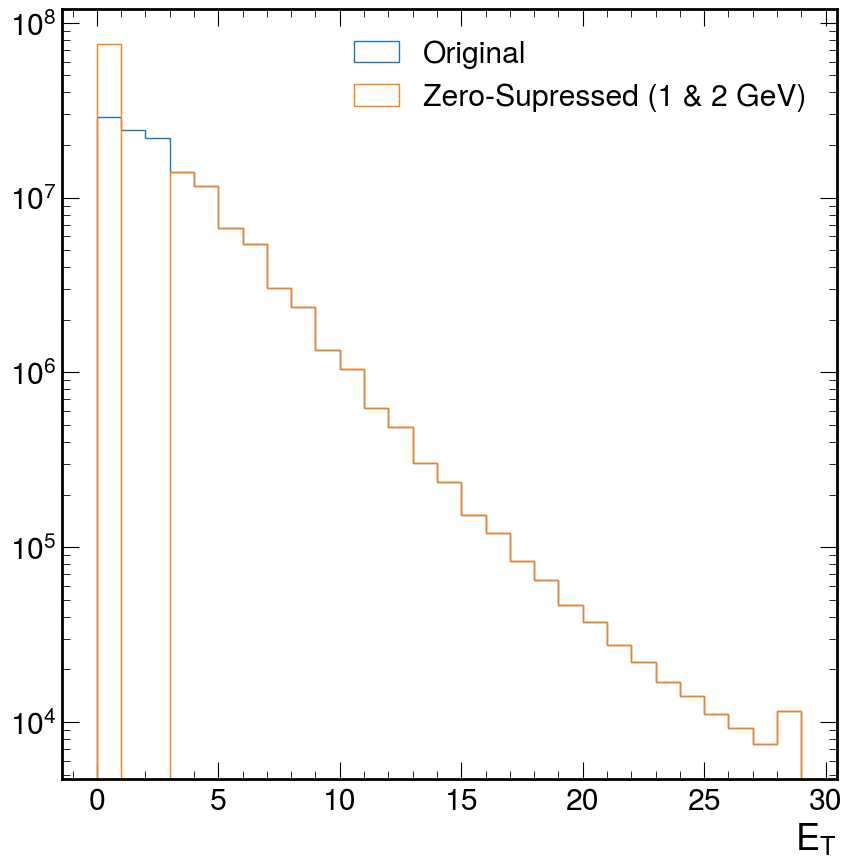

In [228]:
def plot_deposits_distribution(
    deposits: List[npt.NDArray], labels: List[str], name: str,
):
    for deposit, label in zip(deposits, labels):
        plt.hist(
            deposit.reshape((-1)),
            # bins=100,
            bins=range(30),
            # range=(0, 1024),
            # density=1,
            label=label,
            log=True,
            histtype="step",
        )
    plt.xlabel(r"E$_T$")
    plt.legend(loc="best")
    save_fig(f'profiling-deposits-{name}')

plot_deposits_distribution([X_test, X_test_sup], ["Original", "Zero-Supressed (1 & 2 GeV)"], "et-dist-zp")

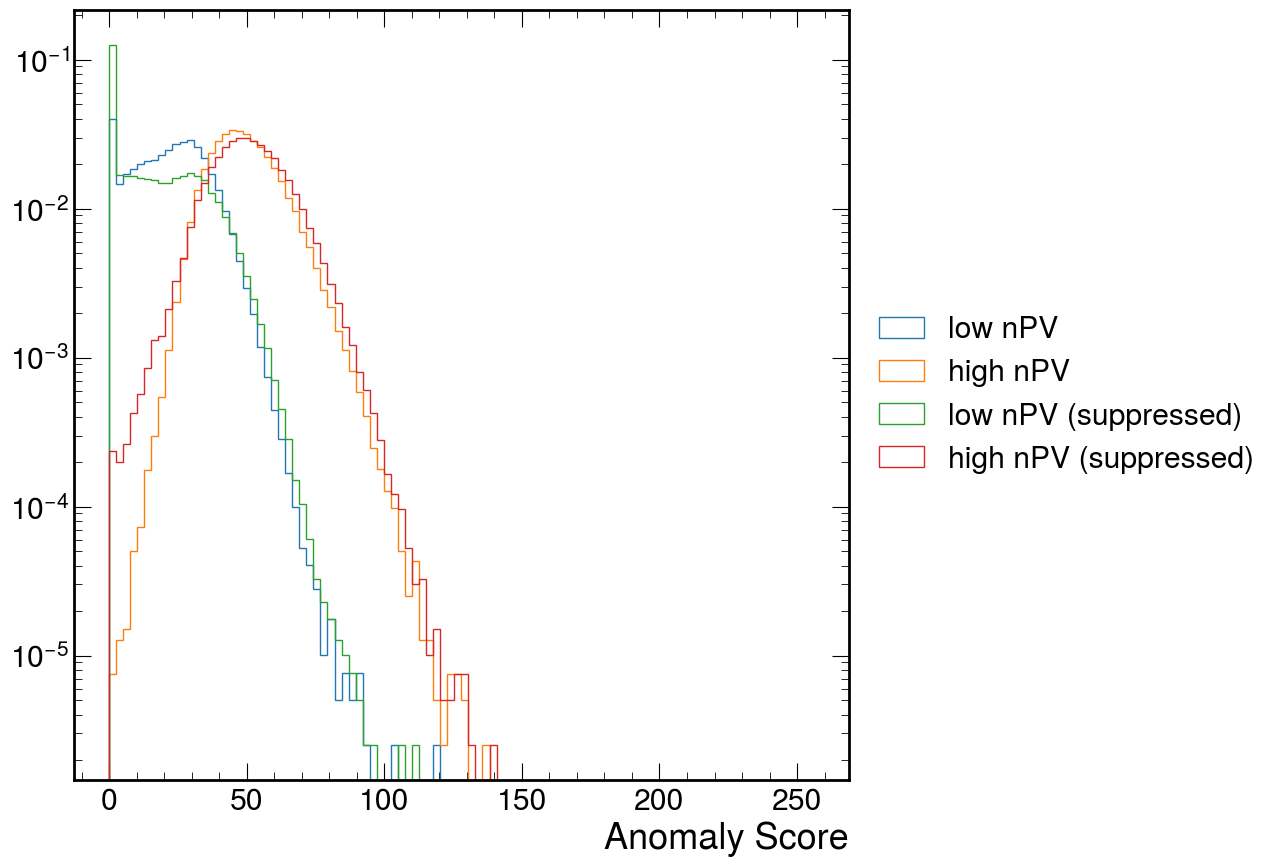

In [229]:
def plot_anomaly_score_distribution(
    scores: List[npt.NDArray], labels: List[str], name: str
):
    for score, label in zip(scores, labels):
        plt.hist(
            score.reshape((-1)),
            bins=100,
            range=(0, 256),
            density=1,
            label=label,
            log=True,
            histtype="step",
        )
    plt.xlabel(r"Anomaly Score")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    save_fig(name)

low_npv = npv_test < np.percentile(npv_test, 33)
high_npv = npv_test > np.percentile(npv_test, 66)

low_npv_scores = student_scores[low_npv]
high_npv_scores = student_scores[high_npv]

low_npv_scores_sup = student_scores_sup[low_npv]
high_npv_scores_sup = student_scores_sup[high_npv]

# plot_anomaly_score_distribution([student_scores, student_scores_sup], ["student", "sup"], "name")
plot_anomaly_score_distribution(
    [low_npv_scores, high_npv_scores, low_npv_scores_sup, high_npv_scores_sup],
    ["low nPV", "high nPV", "low nPV (suppressed)", "high nPV (suppressed)"],
    "anomaly-scores-zp")

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


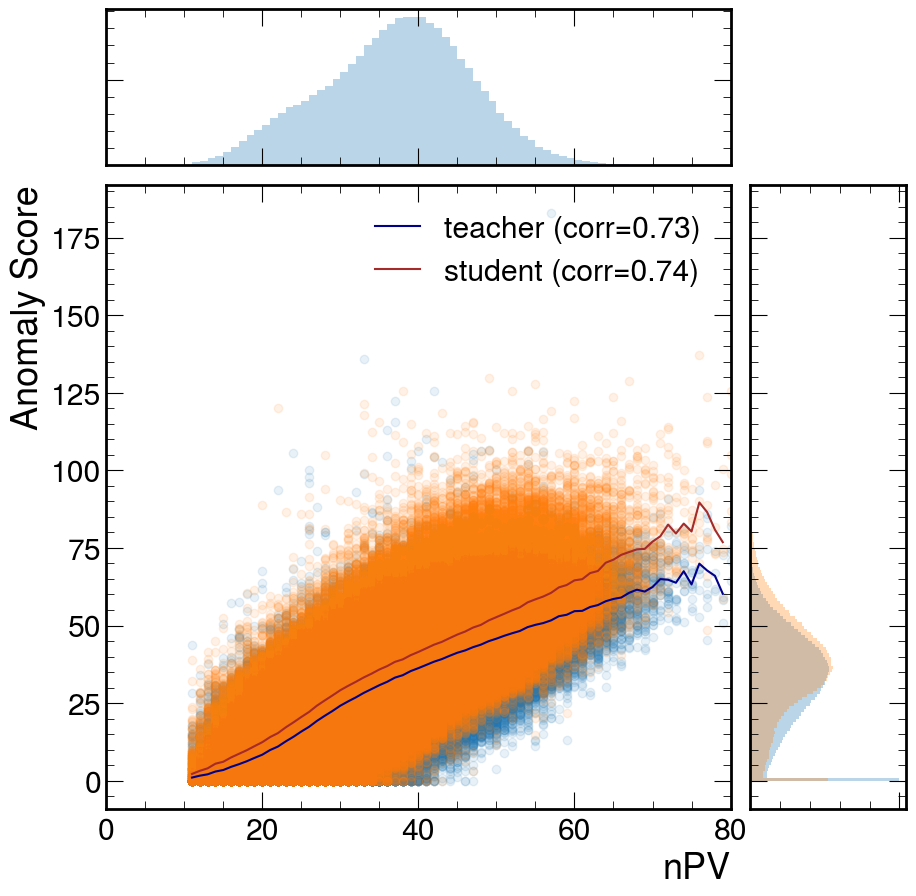

In [237]:
def scatter_hist(x, ys, ls):
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    
    # no labels
    ax_histx.tick_params(axis="x", labelleft=False, labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False, labelbottom=False)
    ax_histy.tick_params(axis="x", labelleft=False, labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False, labelbottom=False)

    ax.set_xlabel("nPV")
    ax.set_ylabel("Anomaly Score")

    # the scatter plot:
    corrs = [np.corrcoef(x, y)[0, 1] for y in ys]

    colors = [("tab:blue", "darkblue"), ("tab:orange", "brown"), ("tab:green", "darkgreen"), ("tab:grey", "black")]

    ax_histx.hist(x, bins=range(80), density=True, alpha=0.3)
    for i, y in enumerate(ys):
        ax.scatter(x, y, alpha=0.1, color=colors[i][0])
        ax_histy.hist(y, bins=range(150), orientation='horizontal', density=True, alpha=0.3, color=colors[i][0])

    means = [[] for _ in ys]
    for n in range(10, 80):
        idx = (x==n)
        for i, y in enumerate(ys):
            s = y[idx]
            means[i].append(np.mean(s))

    for i, l in enumerate(ls):
        ax.plot(range(10, 80), means[i], color=colors[i][1], label=f"{l} (corr={round(corrs[i], 2)})")

    ax.legend(loc="upper right")
    ax.set_xlim((0, 80))

    save_fig("scatter-npv-anomaly-score")


# scatter_hist(npv_test,
#              [teacher_scores, student_scores, teacher_scores_sup, student_scores_sup],
#              ["teacher", "student", "teacher (sup)", "student (sup)"])


scatter_hist(npv_test,
             [teacher_scores, student_scores],
             ["teacher", "student"])


# print(list(scores.keys()))
# names = ["vanilla", "revised", "npv-weighted", "et-decorr-1"]
# names = ["npv-weighted", "revised", "et-decorr-1"]
# names = ["vanilla", "et-decorr-1", "npv-weighted", "et-suppressed"]
# scatter_hist(npv_test,
#              [scores[n] for n in names],
#              names)

# names = ["vanilla", "et-decorr-05", "et-decorr-1"]
# scatter_hist(npv_test,
#              [scores[n] for n in names],
#              names)

# names = ["vanilla", "npv-weighted", "et-suppressed"]
# scatter_hist(npv_test,
#              [scores[n] for n in names],
#              names)

# names = ["revised", "npv-weighted", "et-suppressed"]
# scatter_hist(npv_test,
#              [scores[n] for n in names],
#              names)

1/1 [==============================] - 0s 10ms/step


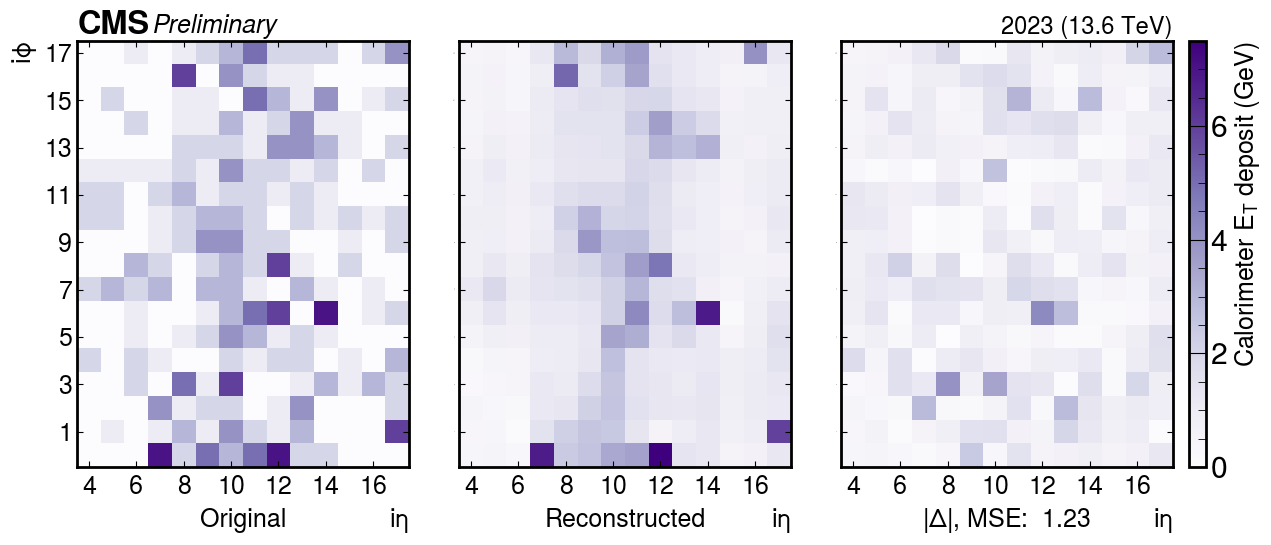

1/1 [==============================] - 0s 10ms/step


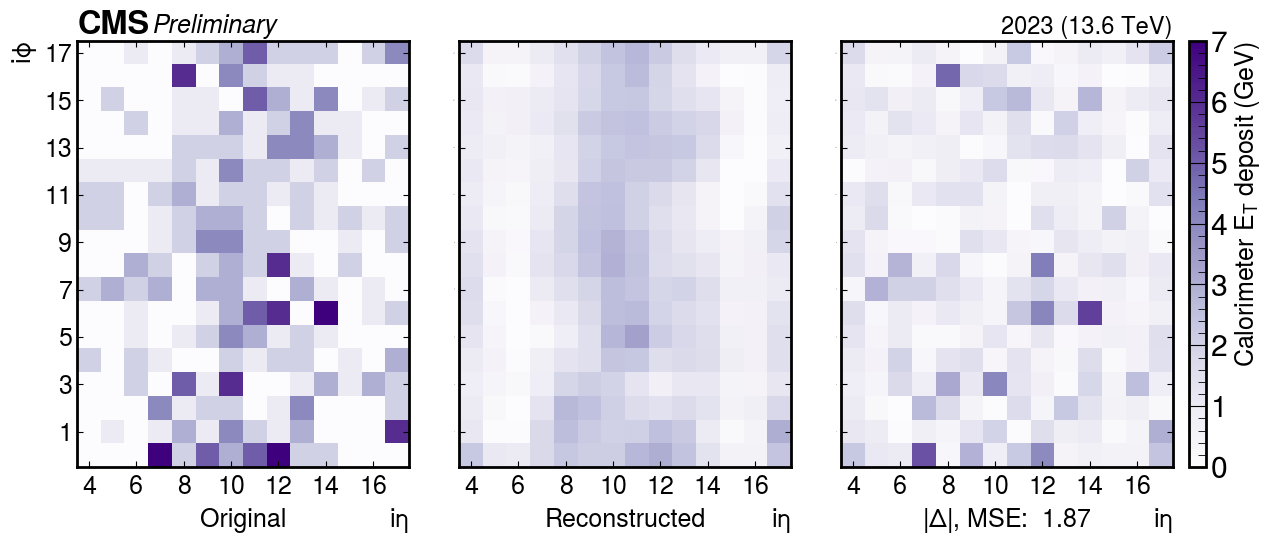

idx = 48745
npv_test[idx] = 111
1/1 [==============================] - 0s 10ms/step


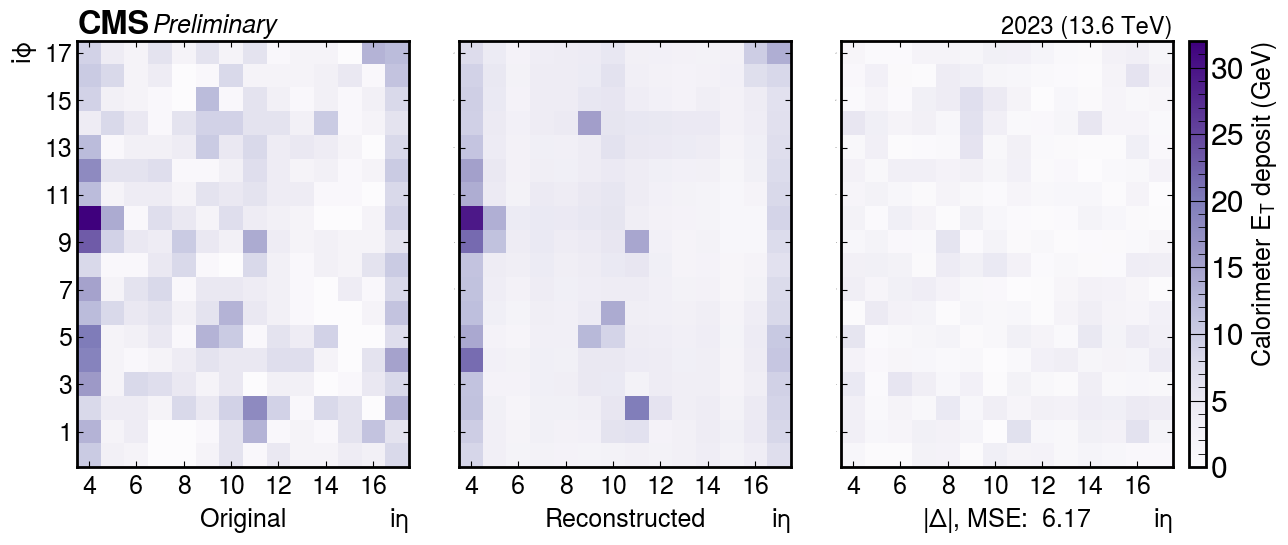

1/1 [==============================] - 0s 9ms/step


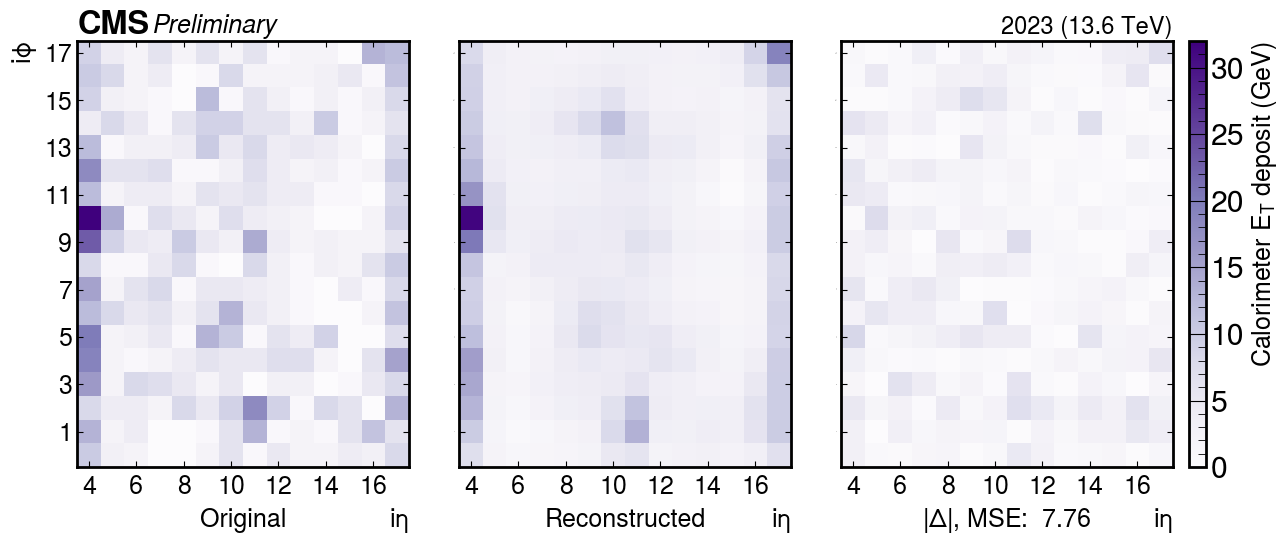

In [ ]:
# Reco Examples for all 3 teachers
X_example = X_test[:1]
y_example = teacher.predict(X_example)
plot_reconstruction_results(
    X_example,
    y_example,
    loss=loss(X_example, y_example)[0],
    name="comparison-background-teacher",
    is_data=True
)
y_example = teacher_et.predict(X_example)
plot_reconstruction_results(
    X_example,
    y_example,
    loss=loss(X_example, y_example)[0],
    name="comparison-background-teacher-re",
    is_data=True
)
# y_example = teacher_w.predict(X_example)
# plot_reconstruction_results(
#     X_example,
#     y_example,
#     loss=loss(X_example, y_example)[0],
#     name="comparison-background-teacher-w",
#     is_data=True
# )


# arr1inds = arr1.argsort()
# sorted_arr1 = arr1[arr1inds[::-1]]
# sorted_arr2 = arr2[arr1inds[::-1]]


idx = np.argmax(npv_test)
print(f'idx = {idx}')
print(f'npv_test[idx] = {npv_test[idx]}')

X_example = X_test[idx:idx+1]
y_example = teacher.predict(X_example)
plot_reconstruction_results(
    X_example,
    y_example,
    loss=loss(X_example, y_example)[0],
    name="comparison-background-teacher",
    is_data=True
)
y_example = teacher_et.predict(X_example)
plot_reconstruction_results(
    X_example,
    y_example,
    loss=loss(X_example, y_example)[0],
    name="comparison-background-teacher-re",
    is_data=True
)
# y_example = teacher_w.predict(X_example)
# plot_reconstruction_results(
#     X_example,
#     y_example,
#     loss=loss(X_example, y_example)[0],
#     name="comparison-background-teacher-w",
#     is_data=True
# )

1/1 [==============================] - 0s 11ms/step


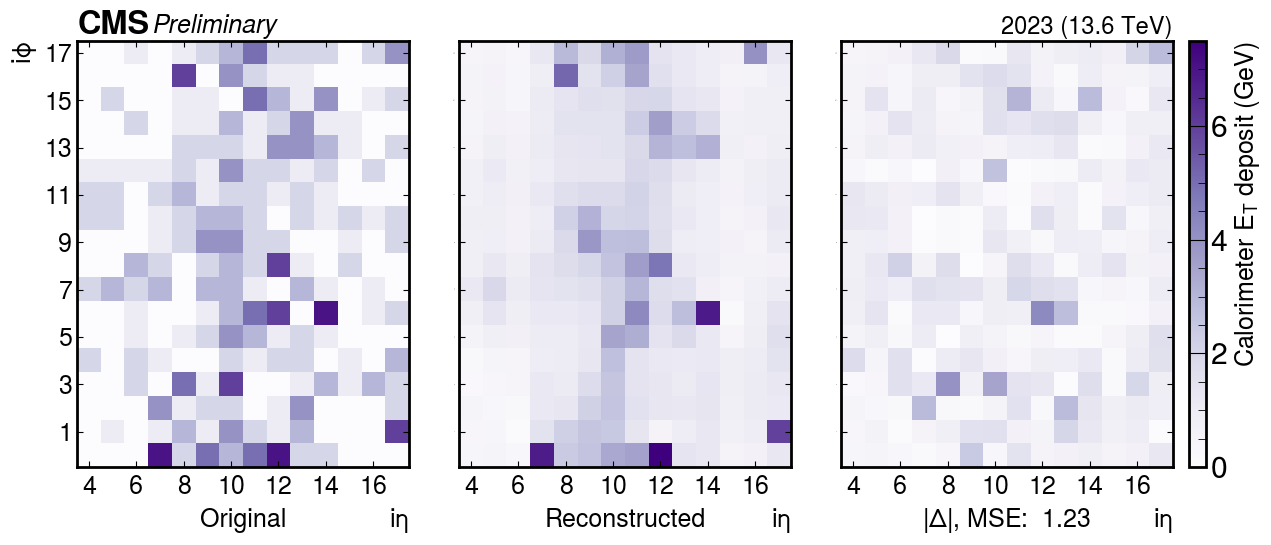

1/1 [==============================] - 0s 11ms/step


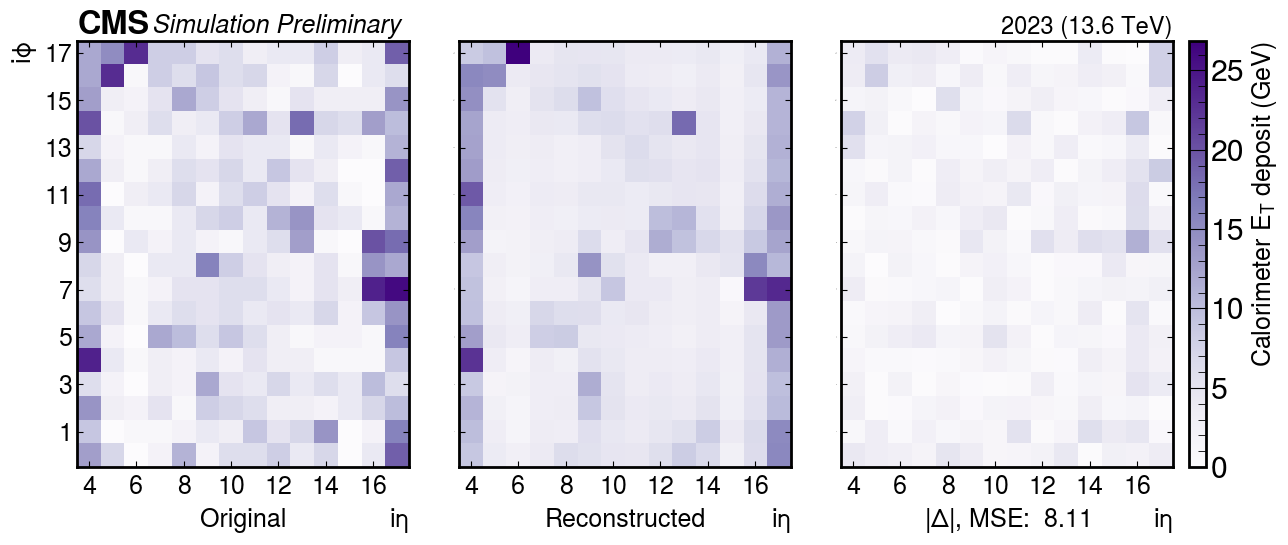

In [137]:
# Comparison between original and reconstructed inputs in single plot

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

def plot_reconstruction_results(
    deposits_in: npt.NDArray,
    deposits_out: npt.NDArray,
    loss: float,
    name: str,
    is_data: bool = False,
):
    fig, (ax1, ax2, ax3, cax) = plt.subplots(
        ncols=4, figsize=(15, 10), gridspec_kw={"width_ratios": [1, 1, 1, 0.05]}
    )
    max_deposit = max(deposits_in.max(), deposits_out.max())

    if is_data:
        hep.cms.text('Preliminary', ax=ax1, fontsize=18)
    else:
        hep.cms.text('Simulation Preliminary', ax=ax1, fontsize=18)
    hep.cms.lumitext('2023 (13.6 TeV)', ax=ax3, fontsize=18)

    ax1.set_title("Original", fontsize=18, y=-0.16)
    ax1.imshow(
        deposits_in.reshape(18, 14), vmin=0, vmax=max_deposit, cmap="Purples"
    )
    
    ax2.set_title("Reconstructed", fontsize=18, y=-0.16)
    ax2.imshow(
        deposits_out.reshape(18, 14), vmin=0, vmax=max_deposit, cmap="Purples"
    )

    ax3.set_title(rf"|$\Delta$|, MSE: {loss: .2f}", fontsize=18, y=-0.16)
    im = ax3.imshow(
        np.abs(deposits_in - deposits_out).reshape(18, 14),
        vmin=0,
        vmax=max_deposit,
        cmap="Purples",
    )

    ax1.set_ylabel(r"i$\phi$", fontsize=18)
    ax1.set_xlabel(r"i$\eta$", fontsize=18)
    ax2.set_xlabel(r"i$\eta$", fontsize=18)
    ax3.set_xlabel(r"i$\eta$", fontsize=18)

    ax1.set_yticks(range(0, 18)[::2], labels=range(0, 18)[::-2], fontsize=18)
    ax2.set_yticks(range(0, 18)[::2], labels=range(0, 18)[::-2], fontsize=0)
    ax3.set_yticks(range(0, 18)[::2], labels=range(0, 18)[::-2], fontsize=0)

    ax1.set_xticks(range(0, 14, 2), labels=range(4, 18, 2), fontsize=18)
    ax2.set_xticks(range(0, 14, 2), labels=range(4, 18, 2), fontsize=18)
    ax3.set_xticks(range(0, 14, 2), labels=range(4, 18, 2), fontsize=18)
    
    ax1.minorticks_off()
    ax1.tick_params(length=4)
    ax2.minorticks_off()
    ax2.tick_params(length=4)
    ax3.minorticks_off()
    ax3.tick_params(length=4)
 
    ip = InsetPosition(ax3, [1.05, 0, 0.05, 1])
    cax.set_axes_locator(ip)
    fig.colorbar(im, cax=cax, ax=[ax1, ax2, ax3]).set_label(
        label=r"Calorimeter E$_T$ deposit (GeV)", fontsize=18
    )

    save_fig(name)


X_example = X_test[:1]
y_example = teacher.predict(X_example)
plot_reconstruction_results(
    X_example,
    y_example,
    loss=loss(X_example, y_example)[0],
    name="comparison-background",
    is_data=True
)

X_example = X_signal["SUSYGGBBH"][48:49]
y_example = teacher.predict(X_example)
plot_reconstruction_results(
    X_example,
    y_example,
    loss=loss(X_example, y_example)[0],
    name="comparison-signal",
)

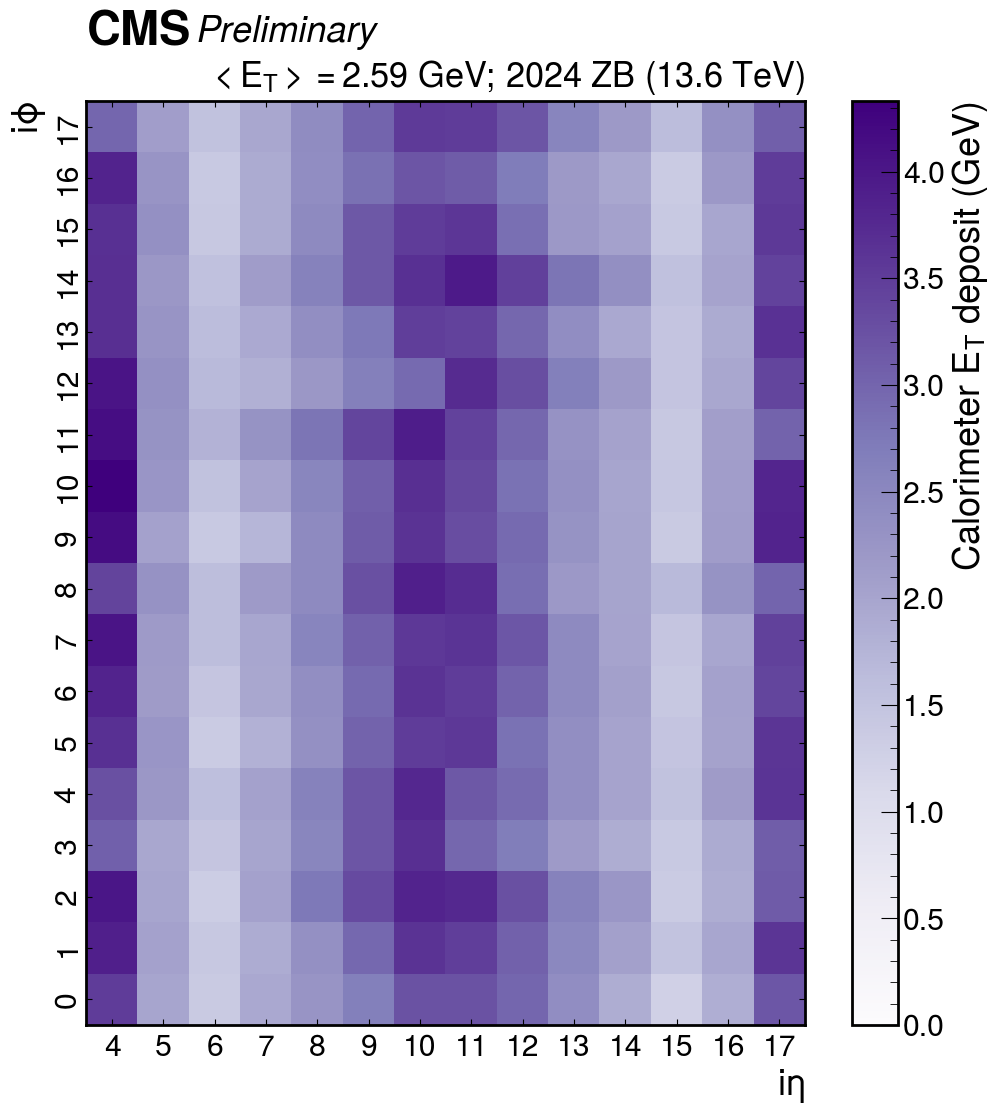

In [5]:
# Profiling training & evaluation data

def plot_regional_deposits(
    deposits: npt.NDArray, mean: float, name: str, is_data: bool = False,
):

    plt.figure(figsize=(12, 12))

    im = plt.imshow(
        deposits.reshape(18, 14), vmin=0, vmax=deposits.max(), cmap="Purples"
    )
    
    ax = plt.gca()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(r"Calorimeter E$_T$ deposit (GeV)")
    
    plt.xticks(np.arange(14), labels=np.arange(4, 18))
    
    plt.yticks(
        np.arange(18),
        labels=np.arange(18)[::-1],
        rotation=90,
        va="center",
    )
    
    plt.xlabel(r"i$\eta$")
    plt.ylabel(r"i$\phi$")

    plt.gca().minorticks_off()
    plt.gca().tick_params(length=4)

    if is_data:
        hep.cms.text('Preliminary', ax=ax, pad=0.05)
    else:
        hep.cms.text('Simulation Preliminary', ax=ax, pad=0.05)

    # verbose title
    if mean is None:
        hep.cms.lumitext(r'(13.6 TeV)', ax=ax)
    else:
        hep.cms.lumitext(rf'$<E_T> = {mean: .2f}$ GeV; {name} (13.6 TeV)')
        # hep.cms.text(rf'$<E_T> = {mean: .2f}$; {name} (13.6 TeV)', ax=ax, pad=0.1)

    save_fig(f'profiling-mean-deposits-{name}')


# for category, dataset in zip(["Background", "Signal"], [config["background"], config["signal"]]):

#     deposits, labels = get_deposits(dataset)

#     for name, X in zip(labels, deposits):
#         plot_regional_deposits(
#             np.mean(X, axis=0).reshape(18, 14), np.mean(X, axis=(0, 1, 2, 3)), name, is_data=(category=='Background')
#         )

plot_regional_deposits(
    np.mean(np.concatenate([X_train,X_val,X_test]), axis=0).reshape(18, 14), np.mean(np.concatenate([X_train,X_val,X_test]), axis=(0, 1, 2, 3)), '2024 ZB', is_data=True
)



# plot_regional_deposits(
#     np.mean(outlier_train, axis=0).reshape(18, 14), np.mean(outlier_train, axis=(0, 1, 2, 3)), 'outlier-train', is_data=False
# )
# plot_regional_deposits(
#     np.mean(outlier_val, axis=0).reshape(18, 14), np.mean(outlier_val, axis=(0, 1, 2, 3)), 'outlier-val', is_data=False
# )

In [ ]:
def plot_anomaly_score_distribution(
    scores: List[npt.NDArray], labels: List[str], name: str, xlabel=r"Anomaly Score", weights=None
):
    for score, label in zip(scores, labels):
        plt.hist(
            score.reshape((-1)),
            bins=range(0, 259, 3),
            # range=(0, 257),
            density=1,
            label=label,
            log=True,
            histtype="step",
            linewidth=2,
        )

    plt.xlabel(xlabel)
    plt.ylabel("a.u.")
    ax = plt.gca()
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], 40*ylim[1])
    ax.set_ylim(0.0000005, 2)
    ax.set_xticks(range(0, 280, 32))    
    
    plt.legend(loc="upper right")
 
    hep.cms.text('Preliminary', loc=1)
    hep.cms.lumitext(r'(13.6 TeV)')
    
    save_fig(name)


as_teacher = quantize(np.log(y_pred_background_teacher)*32)
as_teacher_re = quantize(np.log(y_pred_background_teacher_re)*32)

plot_anomaly_score_distribution(
    [as_teacher, as_teacher_re],
    ["BG Teacher", "BG Teacher2"],
    "anomaly-score-teacher-and-student",
    # "anomaly-score-teacher",
    r"Anomaly Scores"
)

In [29]:
cmap = {
    "2023 Zero Bias": "tab:blue",
    "SUEP": "orange",
    "HtoLongLived": "green",
    "VBFHto2C": "red",
    "TT": "purple",
    "SUSYGGBBH": "brown"
}

In [8]:
# calculate model predictions

y_pred_background_teacher = teacher.predict(X_test, batch_size=512)
y_loss_background_teacher = loss(X_test, y_pred_background_teacher)

results_teacher = {"2023 Zero Bias": y_loss_background_teacher}

inputs, y_true, y_pred_teacher = [], [], []
for name, data in X_signal.items():
    inputs.append(np.concatenate((data, X_test)))

    y_loss_teacher = loss(
        data, teacher.predict(data, batch_size=512)
    )
    results_teacher[name] = y_loss_teacher
    y_true.append(
        np.concatenate((np.ones(data.shape[0]), np.zeros(X_test.shape[0])))
    )
    y_pred_teacher.append(
        np.concatenate((y_loss_teacher, y_loss_background_teacher))
    )


194/194 [==============================] - 4s 20ms/step


label = SUEP
weight =
[1. 1. 1. ... 1. 1. 1.]
label = HtoLongLived
weight =
[1. 1. 1. ... 1. 1. 1.]
label = VBFHto2C
weight =
[1. 1. 1. ... 1. 1. 1.]
label = TT
weight =
[1. 1. 1. ... 1. 1. 1.]
label = SUSYGGBBH
weight =
[1. 1. 1. ... 1. 1. 1.]


/var/folders/rm/c4v4r2pj4zg9qd1xxw_8mzn80000gn/T/ipykernel_48544/647887987.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabel)


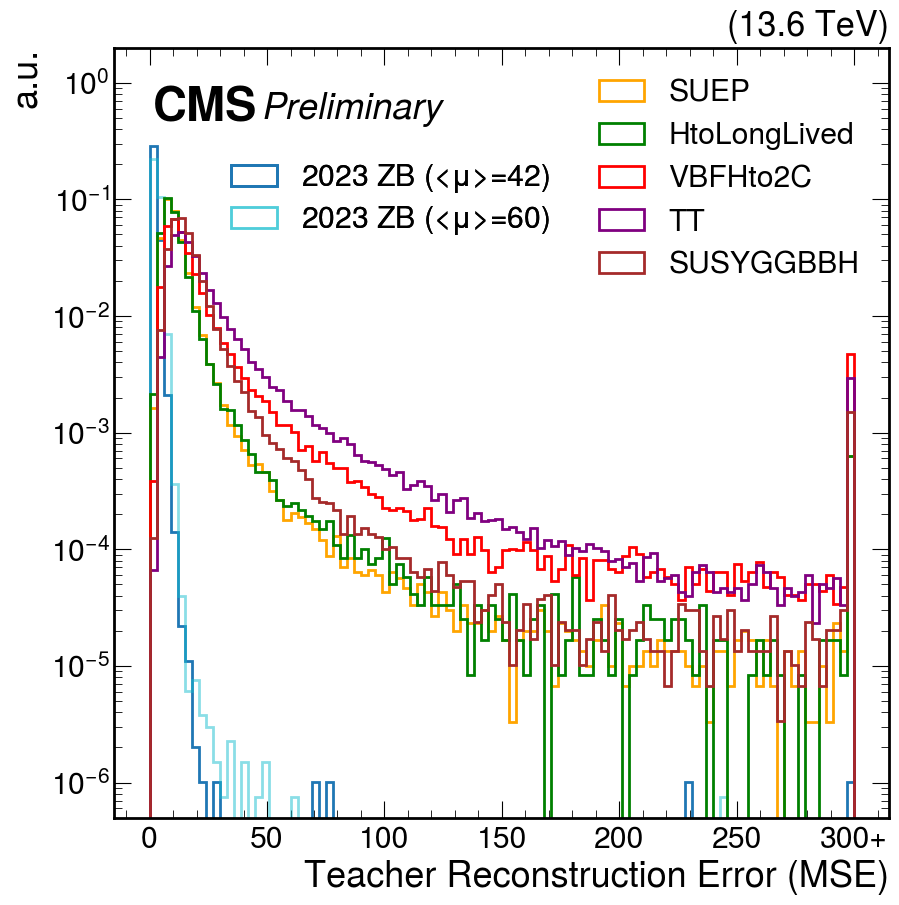

In [30]:
# plot teacher mse dist
hep.style.use('CMS')


def plot_mse_distribution(
    scores: List[npt.NDArray], labels: List[str], name: str, weights = None
):
    # plt.figure(figsize=(8, 8))
    if weights is None:
        weights = {l: np.ones_like(s) for l, s in zip(labels, scores)}

    hs = {}
    bins = np.arange(0, 303, 3)

    label = '2023 Zero Bias'
    idx = labels.index(label)
    score = scores[idx]
    _, _, hs[label] = plt.hist(
        np.clip(score, bins[0], bins[-1]),
        bins=bins,
        density=1,
        # label=label,
        label=r'2023 ZB (<$\mu$>=42)',
        # label=r'2023 ZB',
        log=True,
        histtype="step",
        linewidth=2,
        color=cmap['2023 Zero Bias']
    )

    label = '2024 ZB (Good PU)'
    idx = labels.index(label)
    score = scores[idx]
    _, _, hs[label] = plt.hist(
        np.clip(score, bins[0], bins[-1]),
        bins=bins,
        density=1,
        # label=label,
        label=r'2023 ZB (<$\mu$>=60)',
        log=True,
        histtype="step",
        linewidth=2,
        # color=cmap['2023 Zero Bias'],
        color='tab:cyan',
        alpha=0.5
    )  
    
    for score, label in zip(scores, labels):
        if 'Zero Bias' in label or 'ZB' in label:
            # weight = np.ones_like(score)
            continue
        else:
            weight = weights[label]
        print(f'label = {label}')
        print(f'weight =\n{weight}')
        _, _, hs[label] = plt.hist(
            np.clip(score, bins[0], bins[-1]),
            bins=bins,
            weights=weight,
            density=1,
            label=label,
            log=True,
            histtype="step",
            linewidth=2,
            color=cmap[label]
        )
    plt.xlabel("Teacher Reconstruction Error (MSE)")
    plt.ylabel("a.u.")
    ax = plt.gca()
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], 3*ylim[1])
    ax.set_ylim(0.0000005, 2)
    xticklabel = ax.get_xticklabels()
    xticklabel[-2] = xticklabel[-2].get_text() + '+'
    ax.set_xticklabels(xticklabel)

    signal_keys, data_keys = [], []
    for k in hs.keys():
        if 'ZB' in k or 'Zero Bias' in k:
            data_keys.append(k)
        else:
            signal_keys.append(k)

    l1 = ax.legend(handles=[hs[k][0] for k in signal_keys], loc="lower right", bbox_to_anchor=(1.0, 0.66))
    l2 = ax.legend(handles=[hs[k][0] for k in data_keys], loc="lower right", bbox_to_anchor=(0.6, 0.715), labelspacing=0.3)

    ax.add_artist(l1)
    ax.add_artist(l2)

    # plt.legend(loc="upper right", frameon=False)

    hep.cms.text('Preliminary', loc=1)
    hep.cms.lumitext(r'(13.6 TeV)')

    save_fig(name)

plot_mse_distribution(
    list(results_teacher.values()),
    [*results_teacher],
    "mse-dist-teacher-pu",
    # "mse-dist-teacher",
)

# plot_mse_distribution(
#     list(results_teacher.values()),
#     [*results_teacher],
#     "mse-dist-teacher-pu-weighted",
#     weights=pu_weights
# )

In [212]:
def plot_anomaly_score_distribution(
    scores: List[npt.NDArray], labels: List[str], name: str, xlabel=r"Anomaly Score", weights=None
):
    for score, label in zip(scores, labels):
        plt.hist(
            score.reshape((-1)),
            bins=range(0, 259, 3),
            # range=(0, 257),
            density=1,
            label=label,
            log=True,
            histtype="step",
            linewidth=2,
        )

    plt.xlabel(xlabel)
    plt.ylabel("a.u.")
    ax = plt.gca()
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], 40*ylim[1])
    ax.set_ylim(0.0000005, 2)
    ax.set_xticks(range(0, 280, 32))    
    
    plt.legend(loc="upper right")
 
    hep.cms.text('Preliminary', loc=1)
    hep.cms.lumitext(r'(13.6 TeV)')
    
    save_fig(name)


plot_anomaly_score_distribution(
    # [quantize(np.log(y)*32) for y in [results_teacher['2023 Zero Bias'], results_cicada_v2['2023 Zero Bias']]],
    [quantize(np.log(results_teacher['2023 Zero Bias'])*32), results_cicada_v2['2023 Zero Bias'], quantize(np.log(results_teacher['TT'])*32), results_cicada_v2['TT']],
    ["BG Teacher", "BG Student", "TTbar Teacher", "TTbar Student"],
    "anomaly-score-teacher-and-student",
    # "anomaly-score-teacher",
    r"Anomaly Scores"
)


NameError: name 'results_teacher' is not defined

In [213]:
# plot anomaly scores

def plot_anomaly_score_distribution(
    scores: List[npt.NDArray], labels: List[str], name: str, xlabel=r"Anomaly Score", weights=None
):
    if weights is None:
        weights = {l: np.ones_like(s) for l, s in zip(labels, scores)}

    hs = {}

    label = '2023 Zero Bias'
    idx = labels.index(label)
    score = scores[idx]
    _, _, hs[label] = plt.hist(
        score.reshape((-1)),
        bins=range(0, 259, 3),
        density=1,
        # label=label,
        label=r'2023 ZB (<$\mu$>=42)',
        # label=r'2023 ZB',
        log=True,
        histtype="step",
        linewidth=2,
        color=cmap['2023 Zero Bias']
    )

    label = '2024 ZB (Good PU)'
    idx = labels.index(label)
    score = scores[idx]
    _, _, hs[label] = plt.hist(
        score.reshape((-1)),
        bins=range(0, 259, 3),
        density=1,
        # label=label,
        label=r'2023 ZB (<$\mu$>=60)',
        log=True,
        histtype="step",
        linewidth=2,
        # color=cmap['2023 Zero Bias'],
        color='tab:cyan',
        alpha=0.5
    )    

    for score, label in zip(scores, labels):
        if 'Zero Bias' in label or 'ZB' in label:
            # weight = np.ones_like(score)
            continue
        else:
            weight = weights[label]

        _,_, hs[label] = plt.hist(
            score.reshape((-1)),
            bins=range(0, 259, 3),
            # range=(0, 257),
            density=1,
            weights=weight,
            label=label,
            log=True,
            histtype="step",
            linewidth=2,
            color=cmap[label]
        )

    plt.xlabel(xlabel)
    plt.ylabel("a.u.")
    ax = plt.gca()

    signal_keys, data_keys = [], []
    for k in hs.keys():
        if 'ZB' in k or 'Zero Bias' in k:
            data_keys.append(k)
        else:
            signal_keys.append(k)
        
    l1 = ax.legend(handles=[hs[k][0] for k in signal_keys], loc="lower right", bbox_to_anchor=(1.0, 0.66))
    l2 = ax.legend(handles=[hs[k][0] for k in data_keys], loc="lower right", bbox_to_anchor=(0.6, 0.715), labelspacing=0.3)
    ax.add_artist(l1)
    ax.add_artist(l2)
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], 40*ylim[1])
    ax.set_ylim(0.0000005, 2)
    ax.set_xticks(range(0, 280, 32))    
    
    # plt.legend(loc="upper right")
 
    
    hep.cms.text('Preliminary', loc=1)
    hep.cms.lumitext(r'(13.6 TeV)')
    
    save_fig(name)

plot_anomaly_score_distribution(
    [quantize(np.log(y)*32) for y in results_teacher.values()],
    [*results_teacher],
    "anomaly-score-teacher-pu",
    # "anomaly-score-teacher",
    r"Teacher Anomaly Score"
)
plot_anomaly_score_distribution(
    list(results_cicada_v2.values()),
    [*results_cicada_v2],
    "anomaly-score-cicada-v2-pu",
    # "anomaly-score-cicada-v2",
    r"Student Anomaly Score"
)

# plot_anomaly_score_distribution(
#     [quantize(np.log(y)*32) for y in results_teacher.values()],
#     [*results_teacher],
#     "anomaly-score-teacher-pu-weighted",
#     r"Teacher Anomaly Score",
#     weights=weights_dict
# )
# plot_anomaly_score_distribution(
#     list(results_cicada_v2.values()),
#     [*results_cicada_v2],
#     "anomaly-score-cicada-v2-pu-weighted",
#     r"Student Anomaly Score",
#     weights=weights_dict
# )

# plot_anomaly_score_distribution(
#     [quantize(np.log(y)*32) for y in results_teacher.values()],
#     [*results_teacher],
#     "anomaly-score-teacher-pu-weighted-clip",
#     r"Teacher Anomaly Score",
#     weights=weights_dict_clipped
# )
# plot_anomaly_score_distribution(
#     list(results_cicada_v2.values()),
#     [*results_cicada_v2],
#     "anomaly-score-cicada-v2-pu-weighted-clip",
#     r"Student Anomaly Score",
#     weights=weights_dict_clipped
# )

# plot_anomaly_score_distribution(
#     [quantize(np.log(y)*32) for y in results_teacher.values()],
#     [*results_teacher],
#     "anomaly-score-teacher-pu-weighted-cut",
#     r"Teacher Anomaly Score",
#     weights=weights_dict_cut
# )
# plot_anomaly_score_distribution(
#     list(results_cicada_v2.values()),
#     [*results_cicada_v2],
#     "anomaly-score-cicada-v2-pu-weighted-cut",
#     r"Student Anomaly Score",
#     weights=weights_dict_cut
# )

NameError: name 'results_teacher' is not defined

In [108]:
# calculate model predictions for outliers




# # y_true, y_pred_teacher, y_pred_cicada_v1, y_pred_cicada_v2 = [], [], [], []
# # inputs = []
# for name, data in X_signal.items():

    
#     inputs.append(np.concatenate((data, X_test)))

#     y_loss_teacher = loss(
#         data, teacher.predict(data, batch_size=512)
#     )
#     y_loss_cicada_v2 = cicada_v2.predict(data.reshape(-1, 252, 1), batch_size=512)
#     results_teacher[name] = y_loss_teacher
#     results_cicada_v2[name] = y_loss_cicada_v2

#     y_true.append(
#         np.concatenate((np.ones(data.shape[0]), np.zeros(X_test.shape[0])))
#     )
#     y_pred_teacher.append(
#         np.concatenate((y_loss_teacher, y_loss_background_teacher))
#     )
#     y_pred_cicada_v2.append(
#         np.concatenate((y_loss_cicada_v2, y_loss_background_cicada_v2))
    # )

In [105]:
pu_factor_dict = {}
for proc in ['HtoLongLived', 'SUEP', 'TT', 'VBFHto2C', 'SUSYGGBBH']:
    with open(f'data/PU-factors/{proc}_PU_Factors.json', 'r') as f:
        pu_factor_dict[proc] = json.load(f)

pu_weights = {}
for proc in nPV_signal.keys():
    weights = []
    for npv in nPV_signal[proc]:
        if npv > 100 or npv == 0:
            weights.append(0)
        else:
            weights.append(pu_factor_dict[proc][str(int(npv))])
    pu_weights[proc] = np.array(weights)

# pu_weights['2023 Zero Bias'] = 

for k, v in pu_weights.items():
    print(f'k = {k}, v.shape = {v.shape}')

k = SUEP, v.shape = (100000,)
k = HtoLongLived, v.shape = (40000,)
k = VBFHto2C, v.shape = (98985,)
k = TT, v.shape = (100067,)
k = SUSYGGBBH, v.shape = (98899,)


In [109]:
# # plot teacher & student dist in one plot
# loss_teacher_outlier = loss(
#     outlier_train, teacher.predict(outlier_train, batch_size=512)
# )
# loss_cicada_v2_outlier = cicada_v2.predict(outlier_train.reshape(-1, 252, 1), batch_size=512)

# loss_teacher_bg_train = loss(
#     X_train, teacher.predict(X_train, batch_size=512)
# )
# loss_cicada_v2_bg_train = cicada_v2.predict(X_train.reshape(-1, 252, 1), batch_size=512)


bg_teacher = quantize(np.log(results_teacher['2023 Zero Bias'])*32)
bg_train_teacher = quantize(np.log(loss_teacher_bg_train)*32)
sig_teacher = np.concatenate([quantize(np.log(r)*32) for r in results_teacher.values()])
outlier_teacher = quantize(np.log(loss_teacher_outlier)*32)

bg_cicada_v2 = results_cicada_v2['2023 Zero Bias']
sig_cicada_v2 = np.concatenate(list(results_cicada_v2.values()))

plot_anomaly_score_distribution(
    # [bg_teacher, sig_teacher, bg_cicada_v2, sig_cicada_v2, outlier_teacher, loss_cicada_v2_outlier],
    [bg_teacher, bg_cicada_v2, outlier_teacher, loss_cicada_v2_outlier],
    # [bg_teacher, bg_cicada_v2, bg_train_teacher, loss_cicada_v2_bg_train],
    # ['Zero Bias (Teacher)', 'Signal (Teacher)', 'Zero Bias (Student)', 'Signal (Student)', 'Outlier (Teacher)', 'Outlier (Student)'],
    ['Zero Bias (Teacher)', 'Zero Bias (Student)', 'Outlier (Teacher)', 'Outlier (Student)'],
    # ['Train (Teacher)', 'Train (Student)', 'Val (Teacher)', 'Val (Student)'],
    'anomaly-score-background-outlier',
)
# plot_anomaly_score_distribution(
#     [quantize(np.log(results_teacher[k])*32) for k in keys] + [results_cicada_v2[k] for k in keys],
#     ['2023 Zero Bias (Teacher)', '2023 Zero Bias (Student)', 'a', 'b'],
#     "anomaly-score-teacher",
# )
# plot_anomaly_score_distribution(
#     list(results_cicada_v2.values()),
#     [*results_cicada_v2],
#     "anomaly-score-cicada-v2",
# )

NameError: name 'loss_teacher_bg_train' is not defined

_ = [481.9715  430.62366 366.57834 191.9143  146.53047]
_ = [481.9715  430.62366 366.57834 191.9143  146.53047]
_ = [481.9715  430.62366 366.57834 191.9143  146.53047]
_ = [481.9715  430.62366 366.57834 191.9143  146.53047]
_ = [481.9715  430.62366 366.57834 191.9143  146.53047]


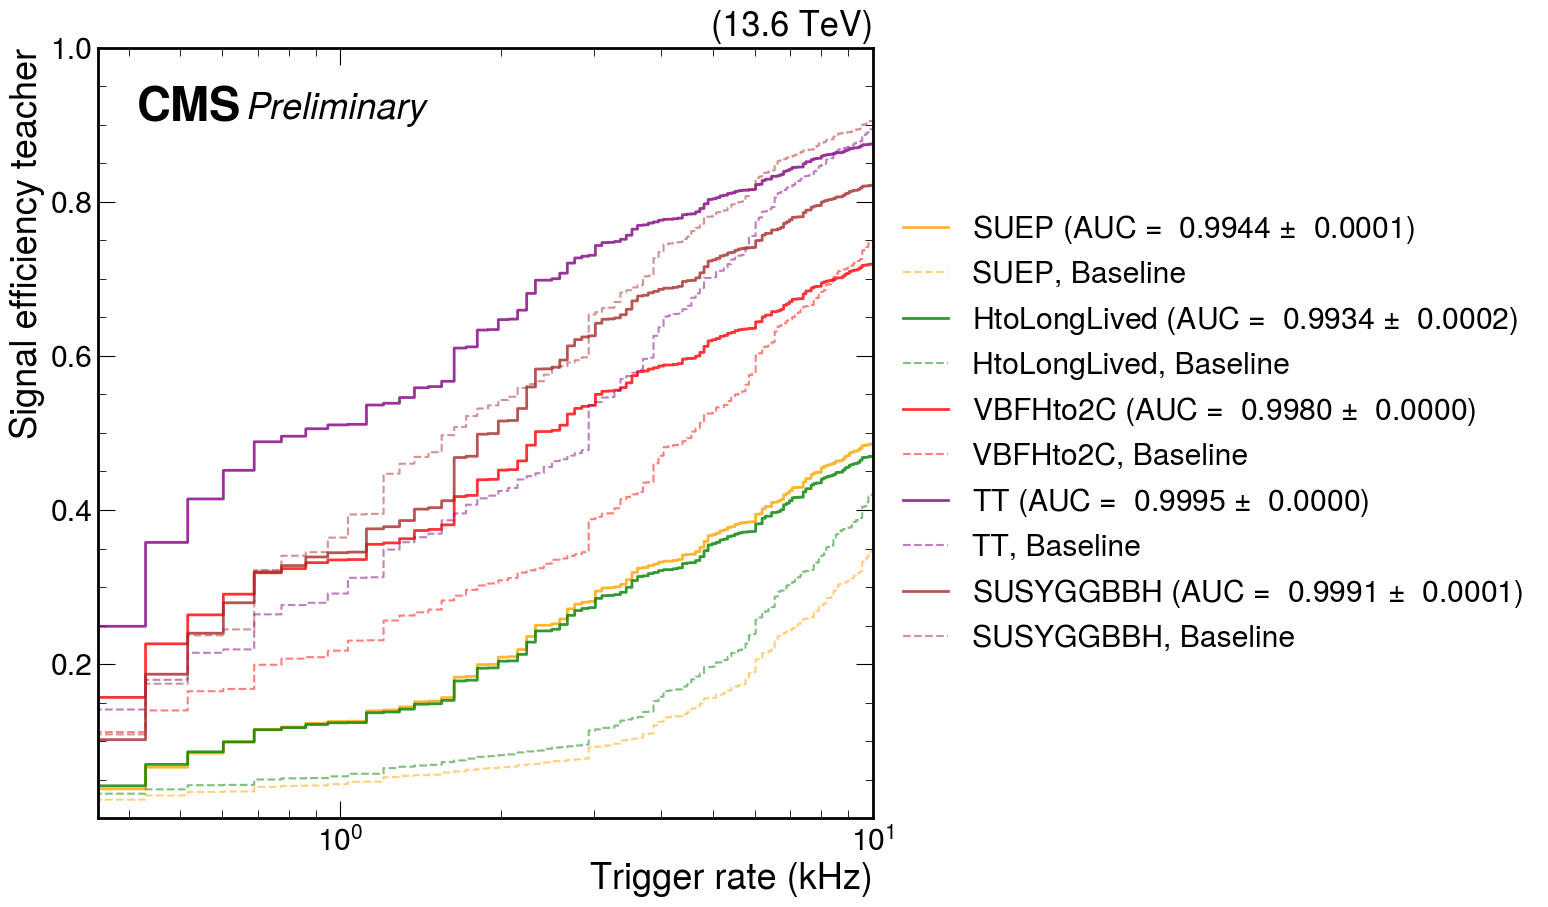

_ = [447.03125 335.27344 223.51562 111.75781   0.     ]
_ = [447.03125 335.27344 223.51562 111.75781   0.     ]
_ = [447.03125 335.27344 223.51562 111.75781   0.     ]
_ = [447.03125 335.27344 223.51562 111.75781   0.     ]
_ = [447.03125 335.27344 223.51562 111.75781   0.     ]


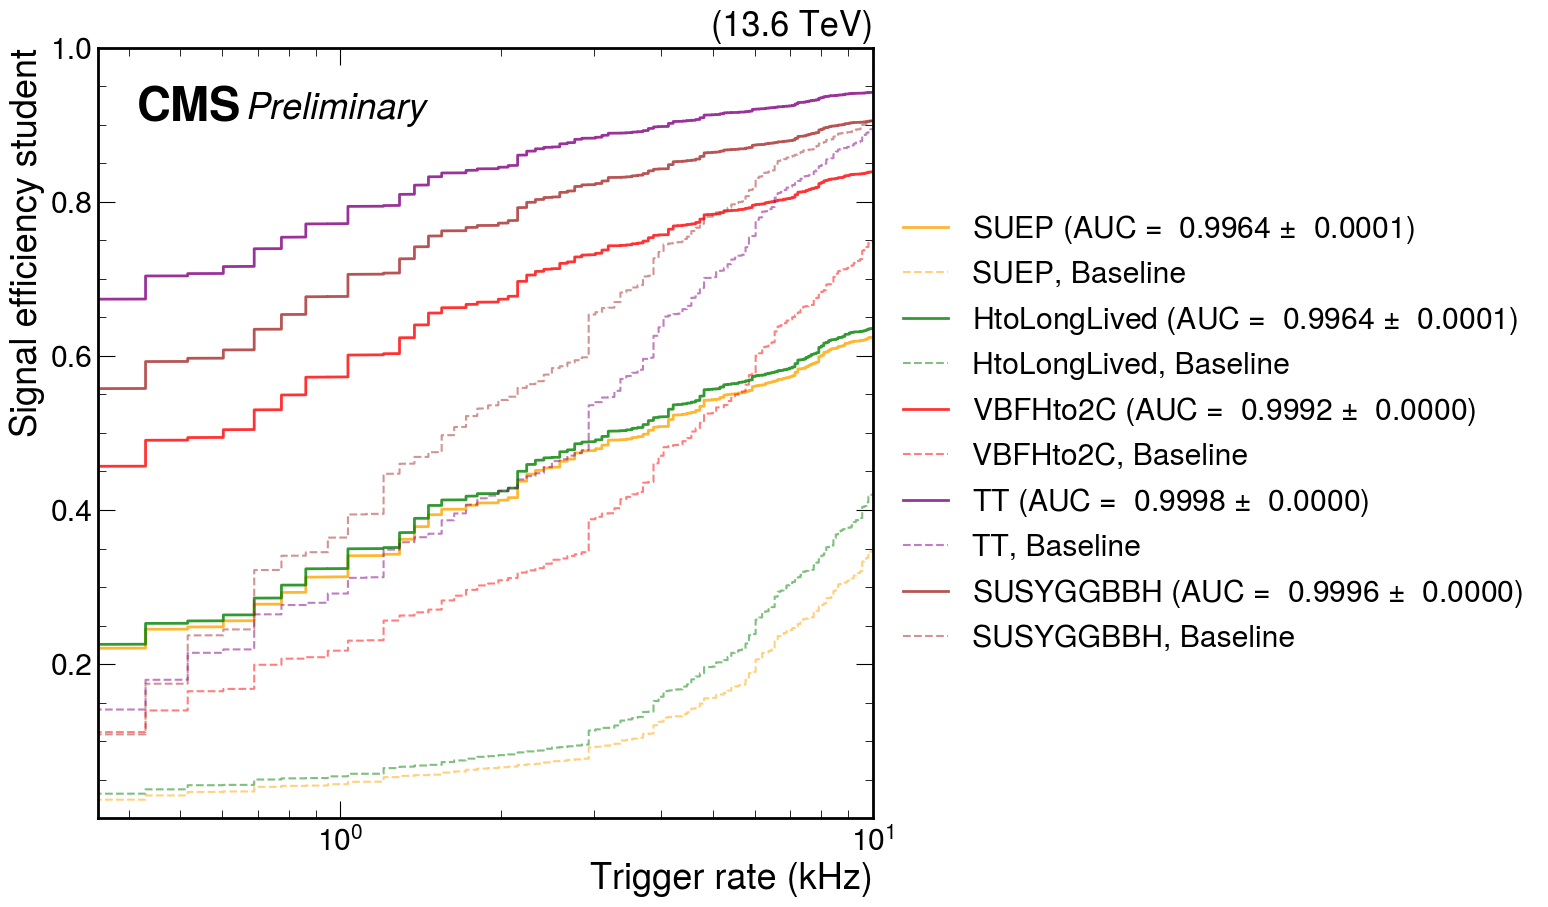

In [20]:
# plot roc curves
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
cmap = ["green", "red", "blue", "orange", "purple", "brown"]

cmap = {
    "2023 Zero Bias": "tab:blue",
    "SUEP": "orange",
    "HtoLongLived": "green",
    "VBFHto2C": "red",
    "TT": "purple",
    "SUSYGGBBH": "brown"
}

# def get_aucs(
#     y_trues: List[npt.NDArray],
#     y_preds: List[npt.NDArray],
#     labels: List[str],
#     inputs: List[npt.NDArray],
#     name: str,
#     cv: int = 3,
#     baseline: str = 'mean'
# ):
#     skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
#     base_line_alg = {
#         'mean': lambda x: np.mean(x**2, axis=(1, 2)),
#         'max': lambda x: np.max(x**2, axis=(1, 2))
#     }[baseline]
#     roc_auc, roc_auc_std = [], []
#     for y_true, y_pred, label, color, d in zip(
#         y_trues, y_preds, labels, cmap, inputs
#     ):
#         aucs = []
#         for _, indices in skf.split(y_pred, y_true):
#             fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
#             aucs.append(auc(fpr, tpr))
#         roc_auc_std.append(np.std(aucs))
#         fpr, tpr, _ = roc_curve(y_true, y_pred)
#         roc_auc.append(auc(fpr, tpr))

#     return roc_auc, roc_auc_std


def plot_roc_curve(
    y_trues: List[npt.NDArray],
    y_preds: List[npt.NDArray],
    labels: List[str],
    inputs: List[npt.NDArray],
    name: str,
    cv: int = 3,
    baseline: str = 'mean',
    ylabel: str = "Signal efficiency",
    weights: dict = None
):

    if weights is None:
        weights = {l: np.ones_like(y) for l, y in zip(labels, y_preds)}

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    base_line_alg = {
        'mean': lambda x: np.mean(x**2, axis=(1, 2)),
        'max': lambda x: np.max(x**2, axis=(1, 2))
    }[baseline]
    for y_true, y_pred, label, color, d in zip(
        y_trues, y_preds, labels, cmap, inputs
    ):
        aucs = []
        for _, indices in skf.split(y_pred, y_true):
            fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices], sample_weight=weights[label][indices])
            aucs.append(auc(fpr, tpr))
        std_auc = np.std(aucs)

        fpr, tpr, _ = roc_curve(y_true, y_pred, drop_intermediate=False, sample_weight=weights[label])
        print(f'_ = {_[-5:]*28610}')
        roc_auc = auc(fpr, tpr)
        fpr_base, tpr_base, _ = roc_curve(y_true, base_line_alg(d), drop_intermediate=False, sample_weight=weights[label])

        plt.plot(
            fpr * 28610,
            tpr,
            linestyle="-",
            lw=2,
            color=cmap[label],
            alpha=0.8,
            label=rf"{label} (AUC = {roc_auc: .4f} $\pm$ {std_auc: .4f})",
        )

        plt.plot(
            fpr_base * 28610,
            tpr_base,
            linestyle="--",
            lw=1.5,
            color=cmap[label],
            alpha=0.5,
            label=rf"{label}, Baseline",
        )

    # plt.plot(
    #     [3, 3],
    #     [0, 1],
    #     linestyle="--",
    #     lw=1,
    #     color="black",
    #     label="3 kHz",
    # )
    # plt.xlim([0.0002861, 28.61])
    # plt.xlim([0.2861, 10])
    plt.xlim([0.35, 10])
    plt.ylim([0.001, 1.0])
    # plt.ylim([0.001, 1.1])
    # plt.ylim([0., 1.0])
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlabel("Trigger rate (kHz)")
    plt.ylabel(ylabel)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
 
    hep.cms.text('Preliminary', loc=1)
    # plt.text(0.415, 0.94, r'Background <$\mu$>=42')
    # plt.text(0.415, 0.94, r'Background <$\mu$>=60')
    hep.cms.lumitext(r'(13.6 TeV)')

    # hep.cms.label('Preliminary', data=True, year=2023, com=13.6, lumi=32.3, loc=1)

    save_fig(name)


# roc_weights = {proc: np.concatenate([weights, np.ones(X_test.shape[0])]) for proc, weights in pu_weights.items()}
# roc_weights = {proc: np.concatenate([weights, np.ones(X_test.shape[0])]) for proc, weights in weights_dict.items()}
# roc_weights_clipped = {proc: np.concatenate([weights, np.ones(X_test.shape[0])]) for proc, weights in weights_dict_clipped.items()}
# roc_weights_cut = {proc: np.concatenate([weights, np.ones(X_test.shape[0])]) for proc, weights in weights_dict_cut.items()}

plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher", ylabel="Signal efficiency teacher")
plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2", ylabel="Signal efficiency student")

# plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher-low-pu", ylabel="Signal efficiency teacher")
# plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2-low-pu", ylabel="Signal efficiency student")

# plot_roc_curve(y_true_good_pu, y_pred_teacher_good_pu, [*X_signal], inputs_good_pu, "roc-teacher-good-pu", ylabel="Signal efficiency teacher")
# plot_roc_curve(y_true_good_pu, y_pred_cicada_v2_good_pu, [*X_signal], inputs_good_pu, "roc-cicada-v2-good-pu", ylabel="Signal efficiency student")

# plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher-pu-weighted", ylabel="Signal efficiency teacher", weights=roc_weights)
# plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2-pu-weighted", ylabel="Signal efficiency student", weights=roc_weights)

# plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher-pu-weighted-clip", ylabel="Signal efficiency teacher", weights=roc_weights_clipped)
# plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2-pu-weighted-clip", ylabel="Signal efficiency student", weights=roc_weights_clipped)

# plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher-pu-weighted-cut", ylabel="Signal efficiency teacher", weights=roc_weights_cut)
# plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2-pu-weighted-cut", ylabel="Signal efficiency student", weights=roc_weights_cut)


# print(get_aucs(y_true, y_pred_teacher, [*X_signal], inputs, 'name'))
# print(get_aucs(y_true, y_pred_cicada_v2, [*X_signal], inputs, 'name'))

In [333]:
# plot roc curves (split sm & bsm)

# sm_labels = ['VBFHto2C', 'TT']
# bsm_labels = ['HtoLongLived', 'SUSYGGBBH']

# y_true_sm, y_pred_teacher_sm, y_pred_cicada_v2_sm, inputs_sm = [], [], [], []
# y_true_bsm, y_pred_teacher_bsm, y_pred_cicada_v2_bsm, inputs_bsm = [], [], [], []

# for i, label in enumerate([*X_signal]):
#     if label in sm_labels:
#         y_true_sm.append(y_true[i])
#         y_pred_teacher_sm.append(y_pred_teacher[i])
#         y_pred_cicada_v2_sm.append(y_pred_cicada_v2[i])
#         inputs_sm.append(inputs[i])
#     if label in bsm_labels:
#         y_true_bsm.append(y_true[i])
#         y_pred_teacher_bsm.append(y_pred_teacher[i])
#         y_pred_cicada_v2_bsm.append(y_pred_cicada_v2[i])
#         inputs_bsm.append(inputs[i])


# # plot_roc_curve(y_true_sm, y_pred_teacher_sm, sm_labels, inputs_sm, "roc-teacher-sm")
# plot_roc_curve(y_true_sm, y_pred_cicada_v2_sm, sm_labels, inputs_sm, "roc-cicada-v2-sm")

# # plot_roc_curve(y_true_bsm, y_pred_teacher_bsm, bsm_labels, inputs_bsm, "roc-teacher-bsm")
# plot_roc_curve(y_true_bsm, y_pred_cicada_v2_bsm, bsm_labels, inputs_bsm, "roc-cicada-v2-bsm")

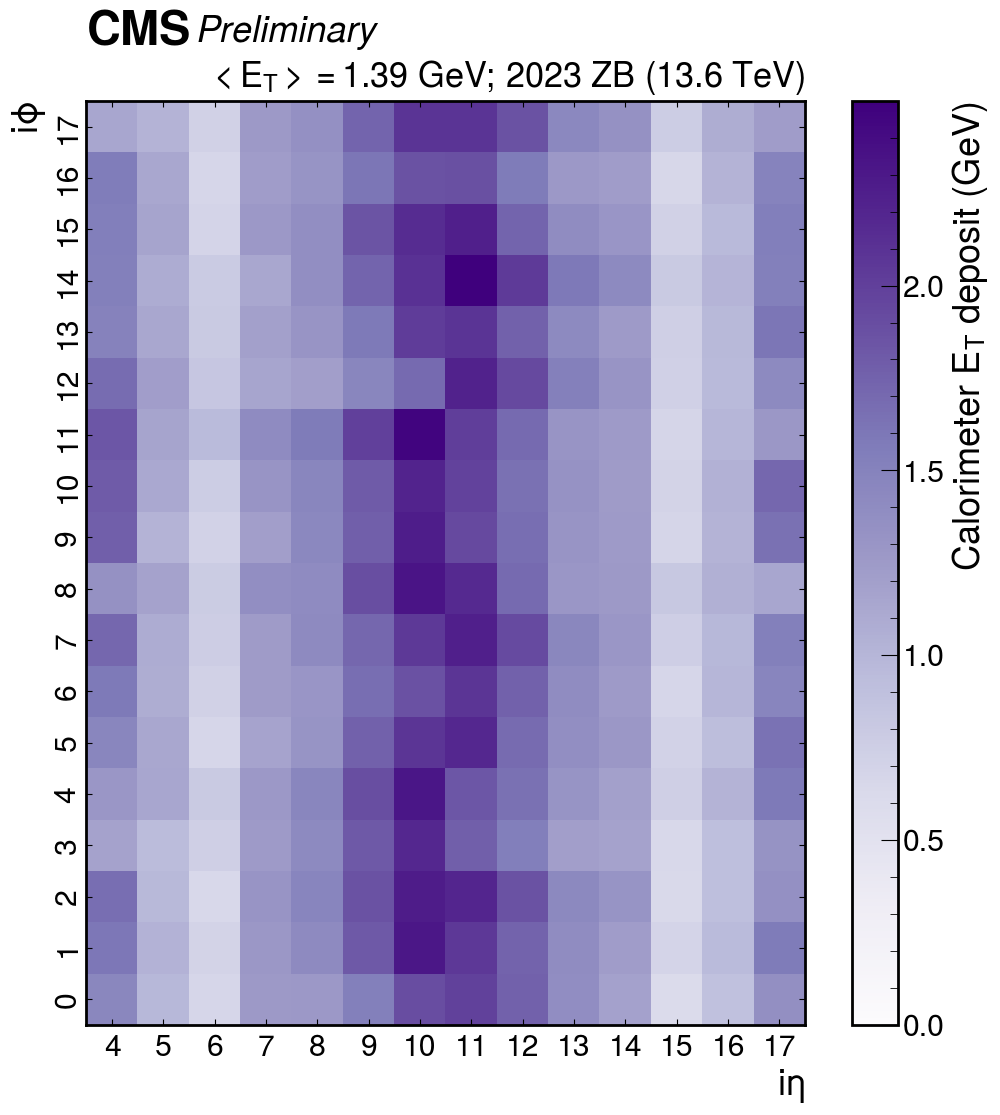

In [22]:
config_old = yaml.safe_load(open('misc/config-macbook.yml'))

datasets_old = [i["path"] for i in config_old["background"] if i["use"]]
datasets_old = [path for paths in datasets_old for path in paths]

gen_old = RegionETGenerator()
X_train_old, X_val_old, X_test_old = gen_old.get_data_split(datasets_old)
plot_regional_deposits(
    np.mean(np.concatenate([X_train_old,X_val_old,X_test_old]), axis=0).reshape(18, 14), np.mean(np.concatenate([X_train_old,X_val_old,X_test_old]), axis=(0, 1, 2, 3)), '2023 ZB', is_data=True
)